[Original Notebook Downloaded From Kaggle](https://www.kaggle.com/bariskavus/diabetes-prediction-randomforestclassifier)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


<a id='begin'></a>
# <h1 style="background-color:skyblue; font-family:newtimeroman; font-size:350%; text-align:center; border-radius: 15px 50px;">Pima Indian</h1>

## This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

<center><img
src="https://www.legendsofamerica.com/wp-content/uploads/2018/12/PimaIndiansCarloGentile1870.jpg" style="width:50%;height:50%;">
</center>

### Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.
<br>

* **Pregnancies: Number of times pregnant**
* **Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test**
* **BloodPressure: Diastolic blood pressure (mm Hg)**
* **SkinThickness: Triceps skin fold thickness (mm)**
* **Insulin: 2-Hour serum insulin (mu U/ml)**
* **BMI: Body mass index (weight in kg/(height in m)^2)**
* **DiabetesPedigreeFunction: Diabetes pedigree function**
* **Age: Age (years**)
* **Outcome: Class variable (0 or 1) 268 of 768 are 1, the others are 0**

<a id='begin'></a>
# <h1 style="background-color:skyblue; font-family:newtimeroman; font-size:350%; text-align:center; border-radius: 15px 50px;">Load Data 📚</h1>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.float_format",lambda x: "%.5f" % x)
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

df = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60000,0.62700,50,1
1,1,85,66,29,0,26.60000,0.35100,31,0
2,8,183,64,0,0,23.30000,0.67200,32,1
3,1,89,66,23,94,28.10000,0.16700,21,0
4,0,137,40,35,168,43.10000,2.28800,33,1


<a id='begin'></a>
# <h1 style="background-color:skyblue; font-family:newtimeroman; font-size:350%; text-align:center; border-radius: 15px 50px;">Check Data 🔎</h1>

In [3]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin      BMI  \
0            6      148             72             35        0 33.60000   
1            1       85             66             29        0 26.60000   
2            8      183             64              0        0 23.30000   

   DiabetesPedigreeFunction  Age  Outcome  
0                   0.62700   50        1  
1                   0.35100   31        0  
2                   0.67200   32        1  
##################### Tail 

### It is not possible for BMI and some variables to be zero. Values equal to zero in the data set are missing values. NA should be written instead of these values.

In [4]:
# We convert values with zero in variables to NaN values.
cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols:
    df[col].replace(0, np.NaN, inplace=True)

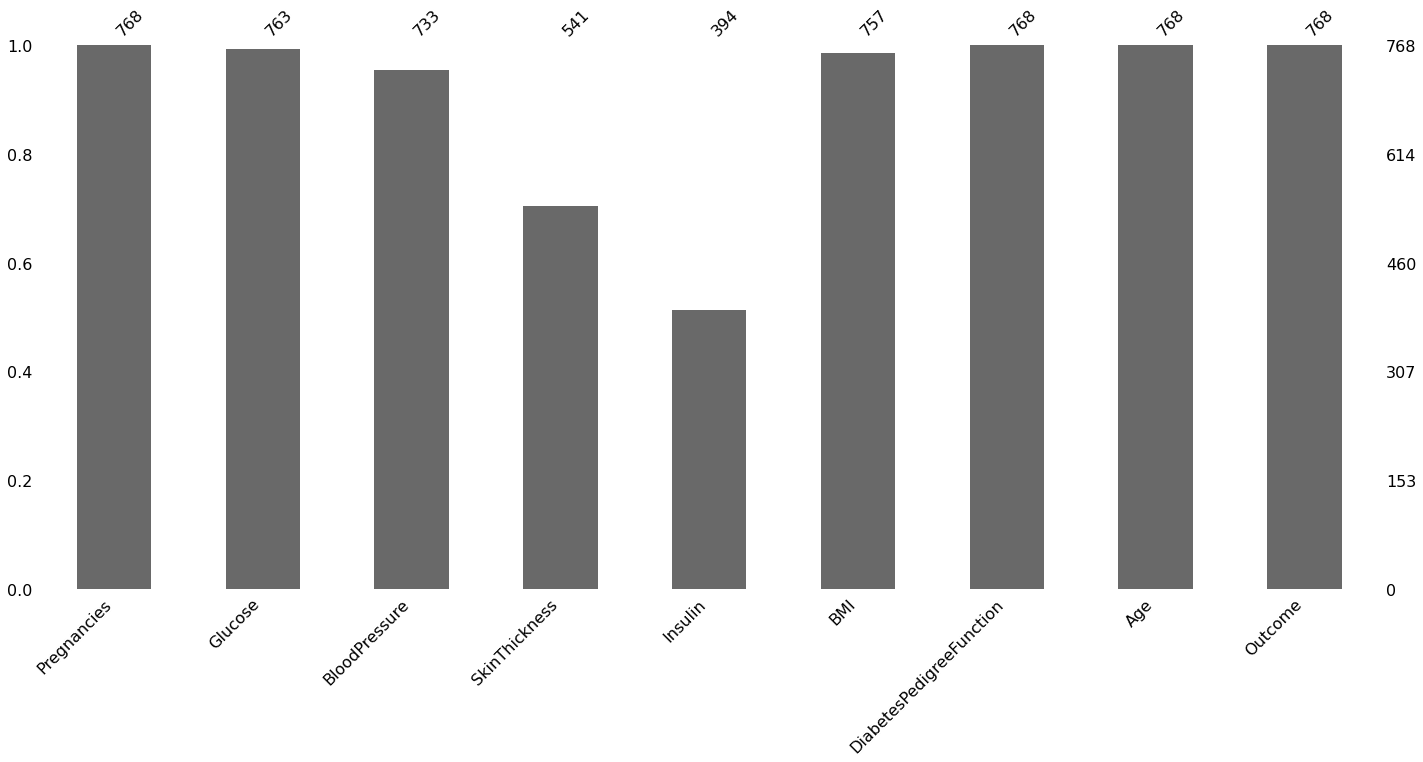

In [5]:
msno.bar(df);

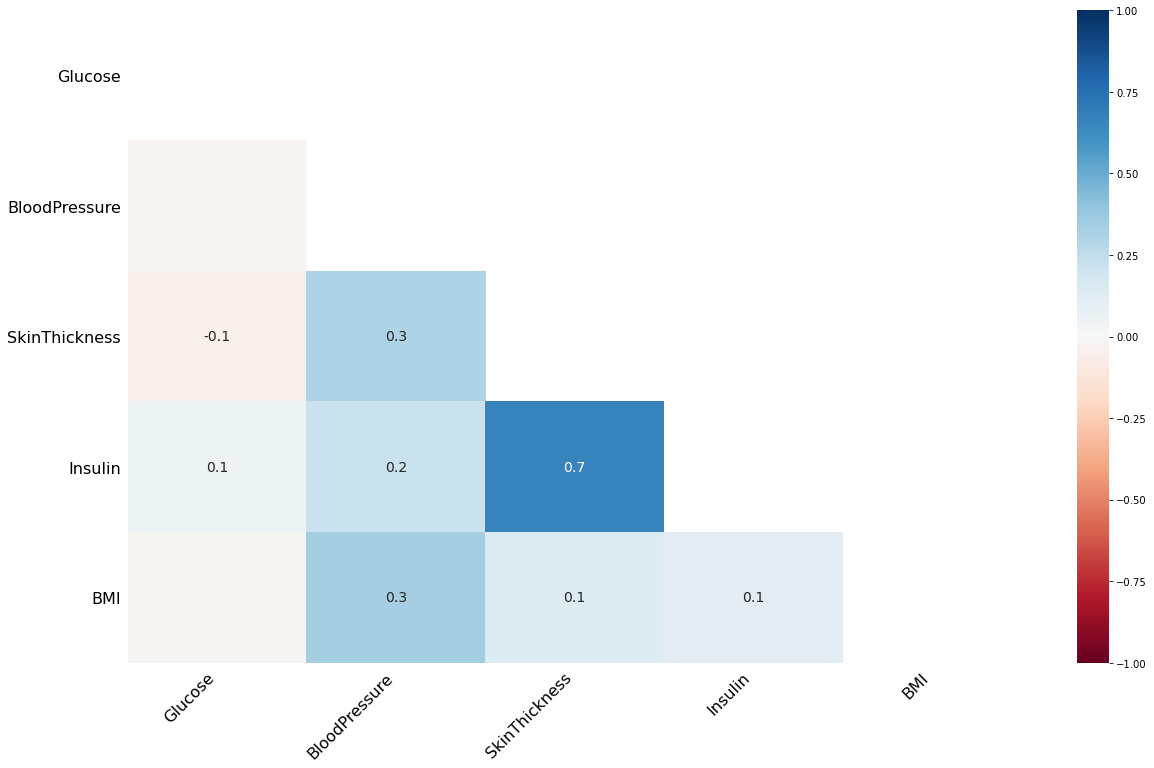

In [6]:
msno.heatmap(df);

<a id='begin'></a>
# <h1 style="background-color:skyblue; font-family:newtimeroman; font-size:350%; text-align:center; border-radius: 15px 50px;">Data Preprocessing 🛠️</h1>

In [7]:
# We can fill in the NaN values with a median relative to the target.
for col in df.columns:
    df.loc[(df["Outcome"] == 0) & (df[col].isnull()), col] = df[df["Outcome"] == 0][col].median()
    df.loc[(df["Outcome"] == 1) & (df[col].isnull()), col] = df[df["Outcome"] == 1][col].median()

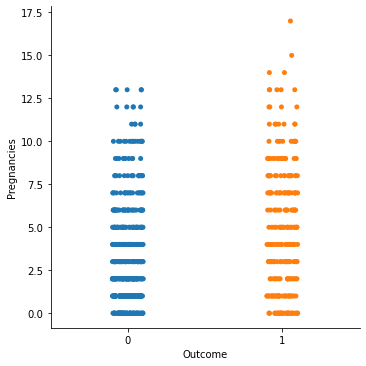

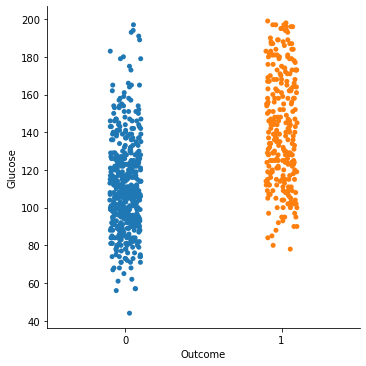

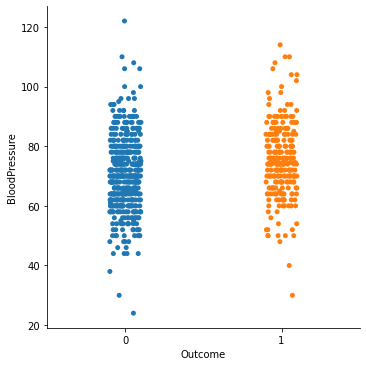

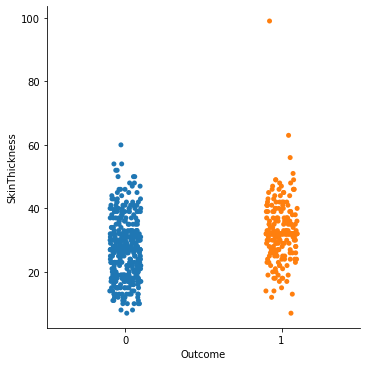

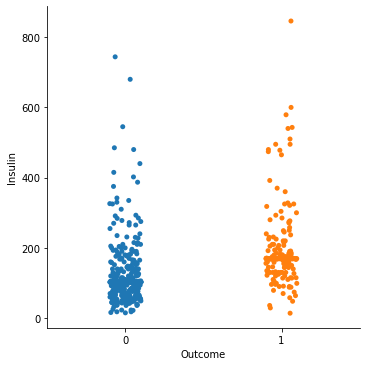

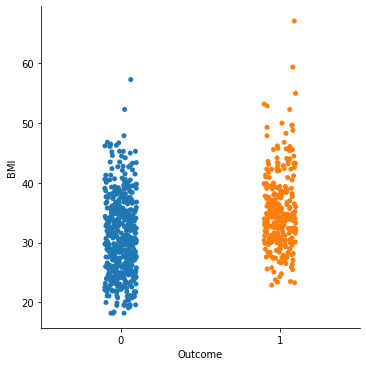

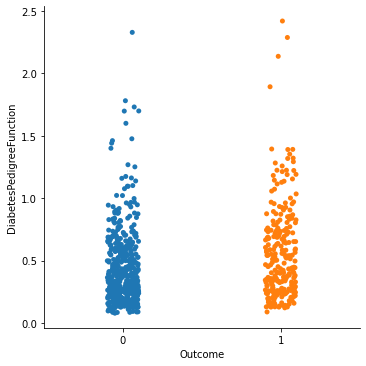

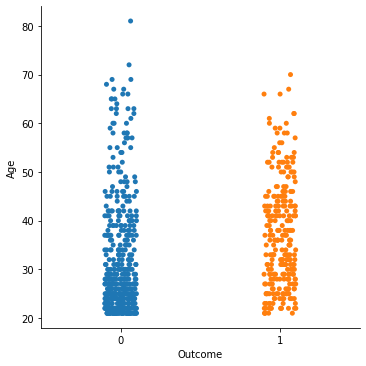

In [8]:
# Outliers visualization
for col in df.columns:
    if col != "Outcome":
        sns.catplot("Outcome", col, data = df)

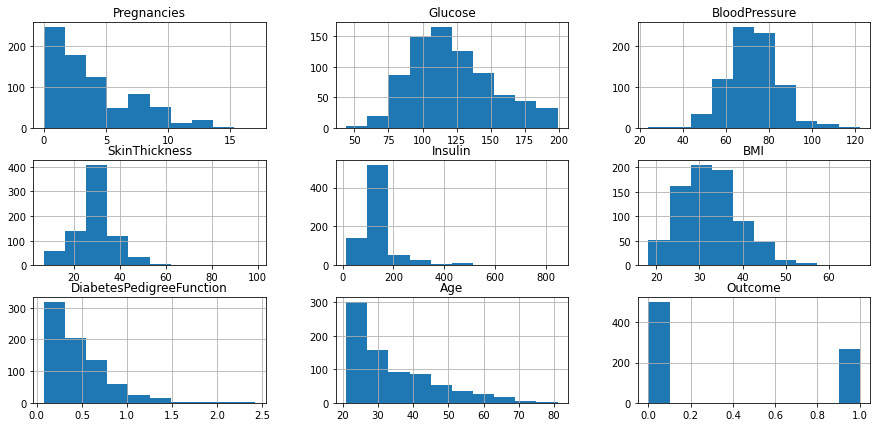

In [9]:
df.hist(figsize = (15,7));

In [10]:
# Outliers
def outlier_thresholds(dataframe, col_name, th1=0.05, th3=0.95):
    quartile1 = dataframe[col_name].quantile(th1)
    quartile3 = dataframe[col_name].quantile(th3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, col_name, th1=0.05, th3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, th1, th3)
    if low_limit > 0:
        dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
        dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit
    else:
        dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

In [11]:
# Numerical columns
num_cols = [col for col in df.columns if df[col].dtypes in [int, float]
            and df[col].nunique() > 10]

In [12]:
# Check Outliers
for col in df.columns:
    print(check_outlier(df, col))

False
False
False
True
True
False
False
False
False


In [13]:
# Replace Outliers
for col in df.columns:
    replace_with_thresholds(df, col)

In [14]:
# Check Outliers
for col in df.columns:
    print(check_outlier(df, col))

False
False
False
False
False
False
False
False
False


<a id='begin'></a>
# <h1 style="background-color:skyblue; font-family:newtimeroman; font-size:350%; text-align:center; border-radius: 15px 50px;"> Feature Engineering ⚙️</h1>

In [15]:
def label_encoder(dataframe, binary_col):
    labelencoder = preprocessing.LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


def rare_analyser(dataframe, target, rare_perc):
    rare_columns = [col for col in dataframe.columns if dataframe[col].dtypes == 'O'
                    and (dataframe[col].value_counts() / len(dataframe) < rare_perc).any(axis=None)]

    for col in rare_columns:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")


def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [16]:
# New categorical BMI
df['NEW_BMI_CAT'] = pd.cut(x=df['BMI'], bins=[0, 18.4, 25.0, 30.0, 70.0],
                           labels=['weakness', 'normal', 'slightly_fat', 'obese']).astype('O')

# New categorical Glucose
df['NEW_GLUCOSE_CAT'] = pd.cut(x=df['Glucose'], bins=[0, 139, 200],
                               labels=['Normal', 'Prediabetes']).astype('O')

#  New categorical BloodPressure
df['NEW_BLOOD_CAT'] = pd.cut(x=df['BloodPressure'], bins=[0, 79, 90, 123],
                             labels=['Normal', 'Hypertension_S1', 'Hypertension_S2']).astype('O')

# New categorical SkinThickness
df['NEW_SKINTHICKNESS_CAT'] = df['SkinThickness'].apply(lambda x: 1 if x <= 18.0 else 0)

# New categorical Insulin
df['NEW_INSULIN_CAT'] = df['Insulin'].apply(lambda x: 'Normal' if 16.0 <= x <=166   else 'Abnormal')

In [17]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_BMI_CAT,NEW_GLUCOSE_CAT,NEW_BLOOD_CAT,NEW_SKINTHICKNESS_CAT,NEW_INSULIN_CAT
0,6.00000,148.00000,72.00000,35.00000,169.50000,33.60000,0.62700,50.00000,1.00000,obese,Prediabetes,Normal,0,Abnormal
1,1.00000,85.00000,66.00000,29.00000,102.50000,26.60000,0.35100,31.00000,0.00000,slightly_fat,Normal,Normal,0,Normal
2,8.00000,183.00000,64.00000,32.00000,169.50000,23.30000,0.67200,32.00000,1.00000,normal,Prediabetes,Normal,0,Abnormal
3,1.00000,89.00000,66.00000,23.00000,94.00000,28.10000,0.16700,21.00000,0.00000,slightly_fat,Normal,Normal,0,Normal
4,0.00000,137.00000,40.00000,35.00000,168.00000,43.10000,2.28800,33.00000,1.00000,obese,Normal,Normal,0,Abnormal


In [18]:
# Label Encoding
label_cols = [col for col in df.columns if df[col].dtypes == 'O' and df[col].nunique() <= 2]
for col in label_cols:
    label_encoder(df, col)

In [19]:
# One_hot Encoding
ohe_cols = [col for col in df.columns if 10 >= len(df[col].unique()) > 2]
df = one_hot_encoder(df, ohe_cols, drop_first=True)

In [20]:
df.columns = [col.upper() for col in df.columns]

In [21]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT,NEW_SKINTHICKNESS_CAT,NEW_INSULIN_CAT,NEW_BMI_CAT_OBESE,NEW_BMI_CAT_SLIGHTLY_FAT,NEW_BMI_CAT_WEAKNESS,NEW_BLOOD_CAT_HYPERTENSION_S2,NEW_BLOOD_CAT_NORMAL
0,6.00000,148.00000,72.00000,35.00000,169.50000,33.60000,0.62700,50.00000,1.00000,1,0,0,1,0,0,0,1
1,1.00000,85.00000,66.00000,29.00000,102.50000,26.60000,0.35100,31.00000,0.00000,0,0,1,0,1,0,0,1
2,8.00000,183.00000,64.00000,32.00000,169.50000,23.30000,0.67200,32.00000,1.00000,1,0,0,0,0,0,0,1
3,1.00000,89.00000,66.00000,23.00000,94.00000,28.10000,0.16700,21.00000,0.00000,0,0,1,0,1,0,0,1
4,0.00000,137.00000,40.00000,35.00000,168.00000,43.10000,2.28800,33.00000,1.00000,0,0,0,1,0,0,0,1


<a id='begin'></a>
# <h1 style="background-color:skyblue; font-family:newtimeroman; font-size:350%; text-align:center; border-radius: 15px 50px;"> Modeling 🧩</h1>

In [22]:
y = df[['OUTCOME']]
X = df.drop('OUTCOME', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

rf = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [23]:
acc_random_forest = round(rf.score(X_test, y_pred) * 100, 2)
acc_random_forest

100.0

<center><img
src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTO00xMsiob_1AgrAfctXJ50--hHtXxBLg3uWJ1Guc4NGm9Y-61QnmuOagYXA2h0XaFkC0&usqp=CAU" style="width:50%;height:50%;">
</center>

# **Cross validation processes to prevent excessive learning.**

In [24]:
rf_params_ = {'max_depth': [3, 6, 10, None],
              'max_features': [3, 5, 15],
              'n_estimators': [100, 500, 700],
              'min_samples_split': [2, 5, 8],
              'min_samples_leaf': [1, 3, 5]}

rf_model = RandomForestClassifier(random_state=42)

rf_cv_model = RandomizedSearchCV(rf_model, rf_params_, cv=5, n_jobs=-1, verbose=1).fit(X_train, y_train)
rf_cv_model = RandomForestClassifier(**rf_cv_model.best_params_).fit(X_train, y_train)
y_pred = rf_cv_model.predict(X_test)
acc_random_forest = round(rf.score(X_test, y_pred) * 100, 2)
acc_random_forest

Fitting 5 folds for each of 10 candidates, totalling 50 fits


97.4